# Declare some variables


In [1]:
train_days=range(6+2)
test_days=[8,9]
basic_set_rows_in_dataset=range(40)
label_row_in_dataset=148
sequence_length = 20
learning_rate=0.001
learning_rate_decay=0
batch_size=500
normalize=False
epoch=100

# Implement the model


In [2]:
from mypkg.model_implementations import RNN_first_try

Using TensorFlow backend.
/Users/liyeukhou/opt/anaconda3/envs/gradProj/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/liyeukhou/opt/anaconda3/envs/gradProj/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/liyeukhou/opt/anaconda3/envs/gradProj/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.in

# Preparation for Training and Testing





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 20, 40)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               56400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 303       
Total params: 56,703
Trainable params: 56,703
Non-trainable params: 0
_________________________________________________________________


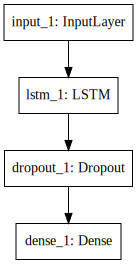

In [3]:
# Load the required packages
from keras.optimizers import Adam
from keras.engine.network import Network
from keras.utils.vis_utils import plot_model, model_to_dot
from IPython.core.display import SVG

# Build the model’s graph
first_model_of_RNN = RNN_first_try(input_shape=(sequence_length, len(basic_set_rows_in_dataset)))

# Compile the model to Configure the learning process
first_model_of_RNN.compile(optimizer=Adam(lr=learning_rate, decay=learning_rate_decay), loss='categorical_crossentropy', metrics=['accuracy'])

# Print the details of layers in a table with the sizes of its inputs/outputs
first_model_of_RNN.summary()

# Plot graph in a nice layout
plot_model(model=first_model_of_RNN, to_file='first_model_of_RNN.png')
SVG(data=model_to_dot(model=first_model_of_RNN).create(prog='dot', format='svg'))

# Generate .pkl files from dataset (Optional)

In [4]:
# Load the required packages
from numpy.lib.npyio import save

from mypkg.generate_pkl import convert_multiple_days_data_to_a_dataframe
train_dataframe=convert_multiple_days_data_to_a_dataframe(selected_train_or_test_days=train_days)
train_dataframe.to_pickle(path='train_dataframe.pkl')
test_dataframe=convert_multiple_days_data_to_a_dataframe(selected_train_or_test_days=test_days)
test_dataframe.to_pickle(path='test_dataframe.pkl')

from mypkg.generate_pkl import offset_for_each_stock_each_day
train_offset=offset_for_each_stock_each_day(selected_train_or_test_days=train_days)
save(file='train_offset',arr=train_offset)
test_offset=offset_for_each_stock_each_day(selected_train_or_test_days=test_days)
save(file='test_offset',arr=test_offset)

# Retrieve from saved .pkl files


In [4]:
# Load the required packages
from pandas.io.pickle import read_pickle
from keras.utils.np_utils import to_categorical
from numpy.lib.npyio import load


train_dataframe = read_pickle(path='train_dataframe.pkl')
test_dataframe = read_pickle(path='test_dataframe.pkl')
train_offset = load(file='train_offset.npy')
# print(type(train_offset))
# print(train_offset.shape)
# print(train_offset)
test_offset = load(file='test_offset.npy')

# Load the dataset


In [5]:
X_train = train_dataframe.iloc[:, basic_set_rows_in_dataset].values  # 提取前40列所有行并转换为numpy形式
Y_train = to_categorical(y=train_dataframe.iloc[:, label_row_in_dataset].values - 1)  # 将真实值转化为0-1向量,向前预测5个period, 用不用-1?
X_test = test_dataframe.iloc[:, basic_set_rows_in_dataset].values
Y_test = to_categorical(y=test_dataframe.iloc[:, label_row_in_dataset].values - 1)

from mypkg.batch_generators import batch_generator_for_RNN

# Training


In [6]:
# Load the required packages
from keras.callbacks import TensorBoard, ModelCheckpoint

from mypkg.batch_counter import batches_amount_per_epoch

# Train the model
a_history_object = first_model_of_RNN.fit_generator(
    generator=batch_generator_for_RNN(normalize=normalize, X_dataset=X_train,Y_dataset=Y_train,offset=train_offset,sequence_length=sequence_length,batch_size=batch_size),
    validation_data=batch_generator_for_RNN(normalize=normalize, X_dataset=X_test,Y_dataset=Y_test,offset=test_offset,sequence_length=sequence_length,batch_size=batch_size),
    steps_per_epoch=batches_amount_per_epoch(offset=train_offset,sequence_length=sequence_length,batch_size=batch_size),
    validation_steps=batches_amount_per_epoch(offset=test_offset,sequence_length=sequence_length,batch_size=batch_size),
    epochs=epoch,
    verbose=2,
    callbacks=[TensorBoard(write_images=True),
               ModelCheckpoint(filepath='E:\liyeukhou\graduation_project\saved_models\weights.{epoch:02d}-{val_loss:.2f}.h5', monitor='loss',save_best_only=True)])

# Auto save the entire model to a HDF5 file
first_model_of_RNN.save(filepath='RNN1.h5')

Epoch 1/100
 - 32s - loss: 1.1960 - acc: 0.4391 - val_loss: 1.1568 - val_acc: 0.3969
Epoch 2/100
 - 31s - loss: 1.0575 - acc: 0.4654 - val_loss: 1.1598 - val_acc: 0.3878
Epoch 3/100
 - 30s - loss: 1.0436 - acc: 0.4677 - val_loss: 1.1647 - val_acc: 0.3836
Epoch 4/100
 - 29s - loss: 1.0440 - acc: 0.4651 - val_loss: 1.1712 - val_acc: 0.3840
Epoch 5/100
 - 29s - loss: 1.0446 - acc: 0.4656 - val_loss: 1.1388 - val_acc: 0.3884
Epoch 6/100
 - 30s - loss: 1.0406 - acc: 0.4682 - val_loss: 1.1629 - val_acc: 0.3852
Epoch 7/100
 - 29s - loss: 1.0373 - acc: 0.4720 - val_loss: 1.1433 - val_acc: 0.3932
Epoch 8/100
 - 30s - loss: 1.0300 - acc: 0.4772 - val_loss: 1.1652 - val_acc: 0.3887
Epoch 9/100
 - 29s - loss: 1.0231 - acc: 0.4821 - val_loss: 1.1441 - val_acc: 0.4045
Epoch 10/100
 - 30s - loss: 1.0194 - acc: 0.4848 - val_loss: 1.1209 - val_acc: 0.4163
Epoch 11/100
 - 29s - loss: 1.0203 - acc: 0.4876 - val_loss: 1.1140 - val_acc: 0.4209
Epoch 12/100
 - 30s - loss: 1.0091 - acc: 0.4943 - val_loss: 1.

# Make sure my model is learning by monitoring the tendency of loss

Text(0, 0.5, 'Cost')

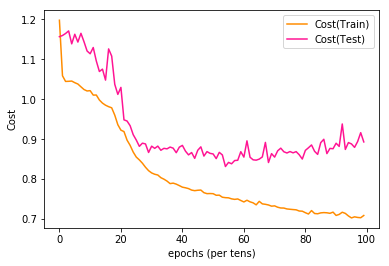

In [7]:
# Load the required packages
import matplotlib.pyplot as pyplot
%matplotlib inline

pyplot.figure()
pyplot.plot(a_history_object.history['loss'], color='darkorange', ls='-', label='Cost(Train)')
pyplot.plot(a_history_object.history['val_loss'], color='deeppink', ls='-', label='Cost(Test)')
pyplot.legend()
pyplot.xlabel(xlabel='epochs (per tens)')
pyplot.ylabel(ylabel='Cost')

# Restore saved model (Optional)

In [8]:
# Load the required packages
from keras.models import load_model

# Recreate the exact same model, including its weights and the optimizer
restored_model = load_model(filepath='RNN1.h5')
print('Model restored.')

Model restored.


# Testing


In [9]:
# Load the required packages
from keras.engine.training import Model
from numpy.core.multiarray import concatenate
from numpy.core._multiarray_umath import ndarray

train_data=batch_generator_for_RNN(normalize=normalize, X_dataset=X_train,Y_dataset=Y_train,offset=train_offset,sequence_length=sequence_length,batch_size=batch_size)
validation_data=batch_generator_for_RNN(normalize=normalize, X_dataset=X_test,Y_dataset=Y_test,offset=test_offset,sequence_length=sequence_length,batch_size=batch_size)
steps_per_epoch=batches_amount_per_epoch(offset=train_offset,sequence_length=sequence_length,batch_size=batch_size)
validation_steps=batches_amount_per_epoch(offset=test_offset,sequence_length=sequence_length,batch_size=batch_size)

Y_train_true_predictions=[]
Y_hat_train_predictions=[]
Y_test_true_predictions=[]
Y_hat_test_predictions=[]

for each_step in range(int(x=steps_per_epoch)):
    temp=next(train_data)  # 长为2的tuple
    Y_train_true_predictions.append(temp[1]) # for几次长度就是几，就是直接把temp[1]这个真实值ndarray附到list里去了
    Y_hat_train_predictions.append(restored_model.predict(x=temp[0]))   # 同上，但是附的是拿[0]计算出来的预测值

for each_step in range(int(x=validation_steps)):
    temp=next(validation_data)
    Y_test_true_predictions.append(temp[1])
    Y_hat_test_predictions.append(restored_model.predict(x=temp[0]))

Y_train_true_predictions=concatenate(Y_train_true_predictions).reshape(-1,3)  # list变ndarray
Y_hat_train_predictions=concatenate(Y_hat_train_predictions).reshape(-1,3)    # list变ndarray
Y_test_true_predictions=concatenate(Y_test_true_predictions).reshape(-1,3)
Y_hat_test_predictions=concatenate(Y_hat_test_predictions).reshape(-1,3)

# Assessment


In [10]:
# Load the required packages
from numpy.core.fromnumeric import argmax
from sklearn.metrics.classification import classification_report,cohen_kappa_score

print('-----How well have we done on training data-----')
y=argmax(Y_train_true_predictions,axis=1)
y_hat=argmax(Y_hat_train_predictions,axis=1)
print(classification_report(y_true=y,y_pred=y_hat))
Cohens_kappa_coefficient=cohen_kappa_score(y1=y,y2=y_hat)
print(f'Cohen Kappa Score = {Cohens_kappa_coefficient}')

print()

print('-----How well have we done on test data-----')
y=argmax(Y_test_true_predictions,axis=1)
y_hat=argmax(Y_hat_test_predictions,axis=1)
print(classification_report(y_true=y,y_pred=y_hat))
Cohens_kappa_coefficient=cohen_kappa_score(y1=y,y2=y_hat)
print(f'Cohen Kappa Score = {Cohens_kappa_coefficient}')

-----How well have we done on training data-----
              precision    recall  f1-score   support

           0       0.67      0.70      0.69    121727
           1       0.62      0.71      0.67     70427
           2       0.71      0.62      0.66    117314

   micro avg       0.67      0.67      0.67    309468
   macro avg       0.67      0.68      0.67    309468
weighted avg       0.67      0.67      0.67    309468

Cohen Kappa Score = 0.498065313030033

-----How well have we done on test data-----
              precision    recall  f1-score   support

           0       0.61      0.63      0.62     29501
           1       0.67      0.69      0.68     26480
           2       0.62      0.58      0.60     27938

   micro avg       0.63      0.63      0.63     83919
   macro avg       0.63      0.63      0.63     83919
weighted avg       0.63      0.63      0.63     83919

Cohen Kappa Score = 0.4490142939952396


# Predictor Visualisation

In [11]:
# Load the required packages
from numpy.lib.function_base import average
from matplotlib.pyplot import title
import matplotlib.pyplot as pyplot
%matplotlib inline

up_movement_contributor=[]
down_movement_contributor=[]

train_data=batch_generator_for_RNN(normalize=normalize, X_dataset=X_train,Y_dataset=Y_train,offset=train_offset,sequence_length=sequence_length,batch_size=batch_size)

for each_batch in range(int(x=steps_per_epoch)):
    temp=next(train_data)[0]    # ???
    # print(type(next(train_data)[0]))
    # print(next(train_data)[0].shape)
    # print(next(train_data)[0])
    y_hat_train=restored_model.predict(x=temp)
    # print(y_hat_train)
    # print()
    up_movement_contributor.append(temp[argmax(a=y_hat_train[:,0])])    # 取第1列
    # print(argmax(a=y_hat_train[:,0]))
    # print()
    down_movement_contributor.append(temp[argmax(a=y_hat_train[:,2])])  # 取第3列
    # print(argmax(a=y_hat_train[:,2]))
    # print()

# print(type(up_movement_contributor))
# print(len(up_movement_contributor))
# print(up_movement_contributor)

In [12]:
up_movement_contributor_avg=average(a=up_movement_contributor,axis=0)
# print(type(up_movement_contributor_avg))
# print(up_movement_contributor_avg.shape)
# print(up_movement_contributor_avg)
down_movement_contributor_avg=average(a=down_movement_contributor,axis=0)

Text(0.5, 1.0, 'volume at bid side')

<Figure size 432x288 with 0 Axes>

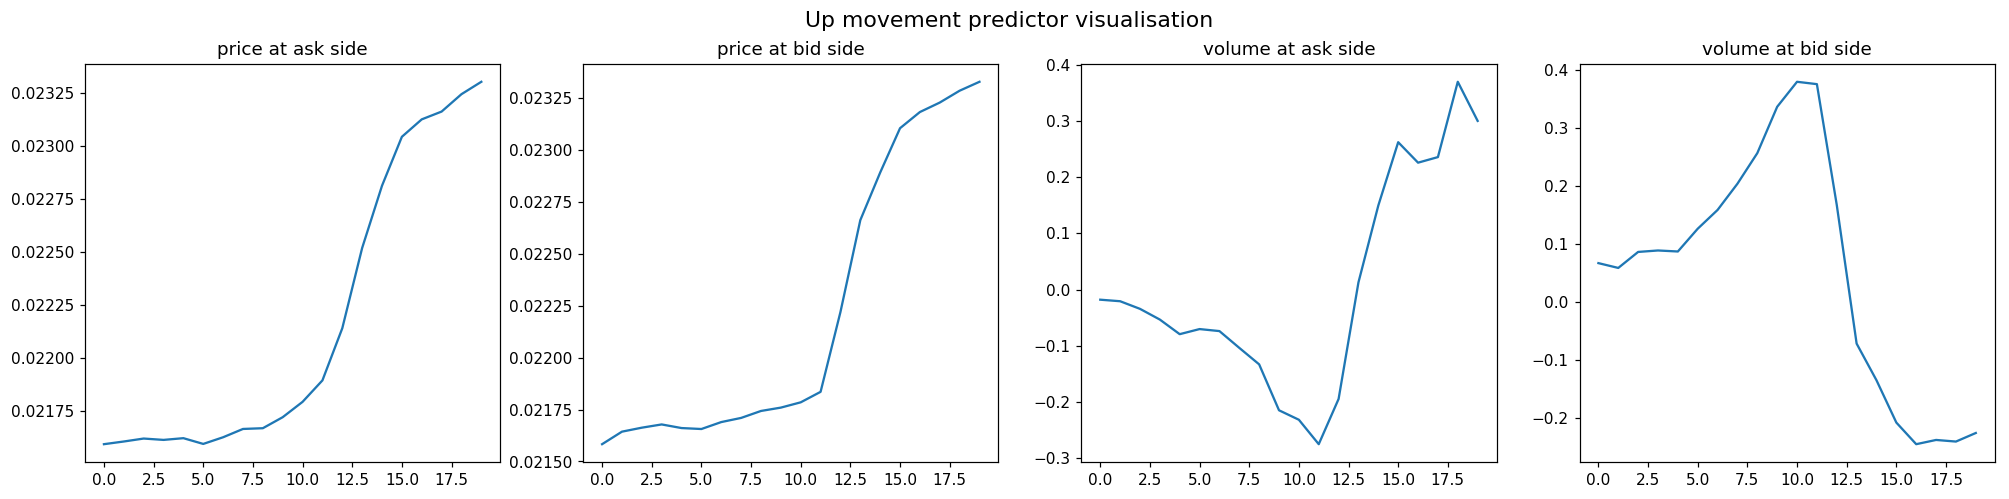

In [13]:
pyplot.tight_layout()

pyplot.figure(figsize=(22.4,4.8),dpi=110)
pyplot.suptitle(t="Up movement predictor visualisation",fontsize='x-large')

pyplot.subplot(1,4,1)
pyplot.plot(up_movement_contributor_avg[:,[0]], ls='-')
title(label='price at ask side')

pyplot.subplot(1,4,2)
pyplot.plot(up_movement_contributor_avg[:,[2]], ls='-')
title(label='price at bid side')

pyplot.subplot(1,4,3)
pyplot.plot(up_movement_contributor_avg[:,[1]], ls='-')
title(label='volume at ask side')

pyplot.subplot(1,4,4)
pyplot.plot(up_movement_contributor_avg[:,[3]], ls='-')
title(label='volume at bid side')

Text(0.5, 1.0, 'volume at bid side')

<Figure size 432x288 with 0 Axes>

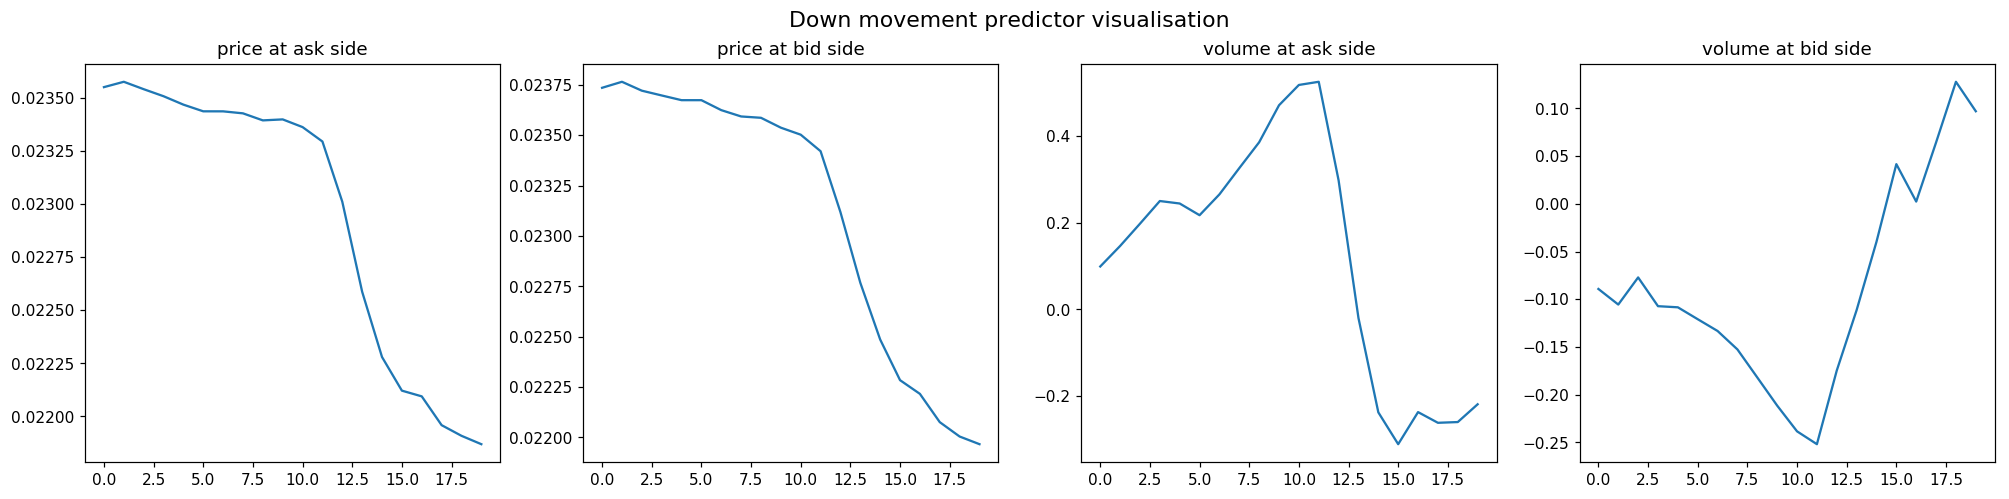

In [14]:
pyplot.tight_layout()

pyplot.figure(figsize=(22.4,4.8),dpi=110)
pyplot.suptitle(t="Down movement predictor visualisation",fontsize='x-large')

pyplot.subplot(1,4,1)
pyplot.plot(down_movement_contributor_avg[:,[0]], ls='-')
title(label='price at ask side')

pyplot.subplot(1,4,2)
pyplot.plot(down_movement_contributor_avg[:,[2]], ls='-')
title(label='price at bid side')

pyplot.subplot(1,4,3)
pyplot.plot(down_movement_contributor_avg[:,[1]], ls='-')
title(label='volume at ask side')

pyplot.subplot(1,4,4)
pyplot.plot(down_movement_contributor_avg[:,[3]], ls='-')
title(label='volume at bid side')